# Shark Project

In [1]:
# The objective in mind for this project:
# Make visualizations to show the different activities people were engaged in
# when they were attacked by sharks? Contrast provokoed vs. unprovoked shark attacks
# Import libraries
import pandas as pd
import numpy as np
import os
import re
import matplotlib
import matplotlib.pyplot as plt

# Import libraries related creating word clouds
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Set max rows higher
pd.set_option('display.max_rows', 7000)

In [2]:
# Load dataset as pandas data frame
# It appears that default utf-8 coding was not working:
# https://stackoverflow.com/a/31492722/5420796
sharks = pd.read_csv("attacks.csv", encoding='latin-1')

In [3]:
# Drop duplicate rows
# It seems like for some reason in the kaggle dataset
# There was a shitload of empty data, you can get rid of it by dropping duplicates
# Here is the database that is more recent:
# https://www.sharkattackfile.net/incidentlog.htm
duplicateRowsDF = sharks[sharks.duplicated()]
sharks.drop_duplicates(inplace=True)

In [4]:
# Confirm that the data has been loaded correctly
sharks.head(n=20)

,Case Number,Date,Year,Type,Country,Area,Location,Activity,Name,Sex,...,Species,Investigator or Source,pdf,href formula,href,Case Number.1,Case Number.2,original order,Unnamed: 22,Unnamed: 23
0,2018.06.25,25-Jun-2018,2018.0,Boating,USA,California,"Oceanside, San Diego County",Paddling,Julie Wolfe,F,...,White shark,"R. Collier, GSAF",2018.06.25-Wolfe.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2018.06.25,2018.06.25,6303.0,NaN,NaN
1,2018.06.18,18-Jun-2018,2018.0,Unprovoked,USA,Georgia,"St. Simon Island, Glynn County",Standing,Adyson McNeely,F,...,NaN,"K.McMurray, TrackingSharks.com",2018.06.18-McNeely.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2018.06.18,2018.06.18,6302.0,NaN,NaN
2,2018.06.09,09-Jun-2018,2018.0,Invalid,USA,Hawaii,"Habush, Oahu",Surfing,John Denges,M,...,NaN,"K.McMurray, TrackingSharks.com",2018.06.09-Denges.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2018.06.09,2018.06.09,6301.0,NaN,NaN
3,2018.06.08,08-Jun-2018,2018.0,Unprovoked,AUSTRALIA,New South Wales,Arrawarra Headland,Surfing,male,M,...,2 m shark,"B. Myatt, GSAF",2018.06.08-Arrawarra.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2018.06.08,2018.06.08,6300.0,NaN,NaN
4,2018.06.04,04-Jun-2018,2018.0,Provoked,MEXICO,Colima,La Ticla,Free diving,Gustavo Ramos,M,...,"Tiger shark, 3m",A .Kipper,2018.06.04-Ramos.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2018.06.04,2018.06.04,6299.0,NaN,NaN
5,2018.06.03.b,03-Jun-2018,2018.0,Unprovoked,AUSTRALIA,New South Wales,"Flat Rock, Ballina",Kite surfing,Chris,M,...,NaN,"Daily Telegraph, 6/4/2018",2018.06.03.b-FlatRock.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2018.06.03.b,2018.06.03.b,6298.0,NaN,NaN
6,2018.06.03.a,03-Jun-2018,2018.0,Unprovoked,BRAZIL,Pernambuco,"Piedade Beach, Recife",Swimming,Jose Ernesto da Silva,M,...,Tiger shark,"Diario de Pernambuco, 6/4/2018",2018.06.03.a-daSilva.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2018.06.03.a,2018.06.03.a,6297.0,NaN,NaN
7,2018.05.27,27-May-2018,2018.0,Unprovoked,USA,Florida,"Lighhouse Point Park, Ponce Inlet, Volusia County",Fishing,male,M,...,"Lemon shark, 3'","K. McMurray, TrackingSharks.com",2018.05.27-Ponce.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2018.05.27,2018.05.27,6296.0,NaN,NaN
8,2018.05.26.b,26-May-2018,2018.0,Unprovoked,USA,Florida,"Cocoa Beach, Brevard County",Walking,Cody High,M,...,"Bull shark, 6'","K.McMurray, TrackingSharks.com",2018.05.26.b-High.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2018.05.26.b,2018.05.26.b,6295.0,NaN,NaN
9,2018.05.26.a,26-May-2018,2018.0,Unprovoked,USA,Florida,"Daytona Beach, Volusia County",Standing,male,M,...,NaN,"K. McMurray, Tracking Sharks.com",2018.05.26.a-DaytonaBeach.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2018.05.26.a,2018.05.26.a,6294.0,NaN,NaN


In [5]:
sharks.drop(['Unnamed: 22', 'Unnamed: 23'], axis=1, inplace=True)

## 1. Case Number

There appers to be a bunc of case numbers with 0.

In [6]:
sharks["Case Number"].describe()

count     6310
unique    6287
top          0
freq         8
Name: Case Number, dtype: object

In [7]:
zerosCaseNumber = sharks.loc[sharks['Case Number'] == '0']
# Remove the rows that have zero in this column
# Inplace makes it so it modifier the original data frame
# https://stackoverflow.com/a/45856125/5420796
sharks.drop(sharks[sharks['Case Number'] == '0'].index, inplace=True)

# 1. Coerce all of the columns that are dates into pandas date time

In [8]:
# Get rid of the 'Reported' that is prepended to certain strings
sharks['Date'] = sharks['Date'].apply(lambda x: re.sub('Reported ', '', str(x)))

In [9]:
sharks['Date'] = pd.to_datetime(sharks['Date'], errors='coerce')

In [10]:
sharks['Date'] = pd.to_datetime(sharks['Date'], errors='coerce')

In [11]:
sharks.isnull().sum()

Case Number                  2
Date                       308
Year                         4
Type                         6
Country                     52
Area                       457
Location                   542
Activity                   546
Name                       212
Sex                        567
Age                       2833
Injury                      30
Fatal (Y/N)                541
Time                      3356
Species                   2840
Investigator or Source      19
pdf                          2
href formula                 3
href                         2
Case Number.1                2
Case Number.2                2
original order               2
dtype: int64

# 2. Year

In [12]:
# Convert the year column to a string column
sharks['Year'] = sharks['Year'].astype(str)
# Loop through removing the ".0 from the year column"
sharks['Year'] = sharks['Year'].apply(lambda x: re.sub("\.0", "", x))

## 3. Type

In [13]:
sharks["Type"].value_counts(dropna=False)

Unprovoked      4595
Provoked         574
Invalid          547
Sea Disaster     239
Boating          203
Boat             137
NaN                6
Questionable       2
Boatomg            1
Name: Type, dtype: int64

As you can see from the above text, there are only 9 cases between NAN, questionable and Boatomg
These cases can be deleted from the analyis

In [14]:
# Drop the columns where it is the type is null
sharks.drop(sharks.loc[sharks['Type'].isnull()].index, inplace=True)
# Drop the columns where the type is questionable
sharks.drop(sharks.loc[sharks['Type'] == 'Questionable'].index, inplace=True)
# Drop the columns where the type is boatomg
sharks.drop(sharks.loc[sharks['Type'] == 'Boatomg'].index, inplace=True)

In [15]:
# Combine boat and boating
sharks['Type'] = sharks['Type'].apply(lambda x: "Boating" if x == "Boat" else x)

In [16]:
sharks["Type"].value_counts(dropna=False)

Unprovoked      4595
Provoked         574
Invalid          547
Boating          340
Sea Disaster     239
Name: Type, dtype: int64

## 4. Remove leading and trailing whitespace of Country column

In [17]:
# Drop trailing and leading whitespeace
sharks['Country'].apply(lambda x: str(x).strip())
sharks['Country'].value_counts()

USA                                      2229
AUSTRALIA                                1335
SOUTH AFRICA                              579
PAPUA NEW GUINEA                          134
NEW ZEALAND                               127
BRAZIL                                    112
BAHAMAS                                   109
MEXICO                                     89
ITALY                                      71
FIJI                                       62
PHILIPPINES                                61
REUNION                                    60
NEW CALEDONIA                              53
CUBA                                       46
MOZAMBIQUE                                 45
SPAIN                                      44
INDIA                                      40
EGYPT                                      38
JAPAN                                      34
CROATIA                                    34
PANAMA                                     32
SOLOMON ISLANDS                   

# 5. Clean up gender in data set using pandas indexing

In [18]:
sharks = sharks[(sharks['Sex ']=='M') | (sharks['Sex ']=='F')]

In [19]:
sharks['Sex '].value_counts()

M    5087
F     637
Name: Sex , dtype: int64

# 6. Clean up species column

In [20]:
# First we want to group similar species of sharks together

In [21]:
# Group swimming categories together
sharks['Species '] = sharks['Species '].apply(lambda x: "White shark" if "white" in str(x).lower() else x)
sharks['Species '] = sharks['Species '].apply(lambda x: "Bull shark" if "bull" in str(x).lower() else x)
sharks['Species '] = sharks['Species '].apply(lambda x: "Zambesi shark" if "zambesi" in str(x).lower() else x)
sharks['Species '] = sharks['Species '].apply(lambda x: "Hammerhead shark" if "hammerhead" in str(x).lower() else x)
sharks['Species '] = sharks['Species '].apply(lambda x: "Bronze whaler shark" if "bronze" in str(x).lower() else x)
sharks['Species '] = sharks['Species '].apply(lambda x: "Wobbegong shark" if "wobbegong" in str(x).lower() else x)
sharks['Species '] = sharks['Species '].apply(lambda x: "Blacktip shark" if "blacktip" in str(x).lower() else x)
sharks['Species '] = sharks['Species '].apply(lambda x: "Grey nurse shark" if "grey" in str(x).lower() else x)
sharks['Species '] = sharks['Species '].apply(lambda x: "Raggedtooth shark" if "raggedtooth" in str(x).lower() else x)
sharks['Species '] = sharks['Species '].apply(lambda x: "Grey nurse shark" if "grey" in str(x).lower() else x)
sharks['Species '] = sharks['Species '].apply(lambda x: "Mako shark" if "mako" in str(x).lower() else x)

    

In [22]:
# Then for all other categories just return other, this bit of code could reduced quite a bit
sharks['Species '] = sharks['Species '].apply(lambda x: "Unknown" if "White shark" not in str(x) 
                                              and "Tiger Shark" not in str(x)
                                              and "Bull shark" not in str(x)
                                              and "Wobbegong shark" not in str(x)
                                              and "Blacktip shark" not in str(x)
                                              and "Bronze whaler shark" not in str(x)
                                              and "Raggedtooth shark" not in str(x)
                                              and "Mako shark" not in str(x)
                                              and "Zambesi shark" not in str(x)
                                              and "Grey nurse shark" not in str(x)
                                              and "Hammerhead shark" not in str(x)
                                              else x)

In [23]:
sharks['Species '].value_counts()

Unknown                4544
White shark             582
Bull shark              177
Blacktip shark           98
Bronze whaler shark      61
Grey nurse shark         60
Wobbegong shark          49
Hammerhead shark         44
Mako shark               43
Raggedtooth shark        41
Zambesi shark            25
Name: Species , dtype: int64

# 7. Convert all of the times to miliatary time time

In [24]:
sharks['Time'].value_counts()

Afternoon                                                                177
11h00                                                                    126
Morning                                                                  114
15h00                                                                    107
12h00                                                                    101
16h00                                                                     98
14h00                                                                     95
16h30                                                                     74
14h30                                                                     71
17h00                                                                     70
13h00                                                                     69
17h30                                                                     69
18h00                                                                     67

In [25]:
sharks['Time'] = pd.to_datetime(sharks['Time'], format='%Hh%M', infer_datetime_format=True, errors = 'coerce').dt.hour

In [26]:
sharks['Time'] = sharks['Time'].apply(lambda x: str(x).replace('.0', 'h00'))

# 7. Clean up fatal column

In [27]:
sharks['Fatal (Y/N)'].value_counts()

N          3937
Y          1277
UNKNOWN      40
 N            7
y             1
M             1
2017          1
Name: Fatal (Y/N), dtype: int64

In [28]:
sharks['Fatal (Y/N)'] = sharks['Fatal (Y/N)'].apply(lambda x: "N" if "n" in str(x).lower()
                                                    and "UNKNOWN" not in str(x) else x)

sharks['Fatal (Y/N)'] = sharks['Fatal (Y/N)'].apply(lambda x: "Y" if "y" in str(x).lower() else x)

sharks['Fatal (Y/N)'] = sharks['Fatal (Y/N)'].apply(lambda x: "UNKNOWN" if "n" not in str(x).lower()
                                                   and "y" not in str(x).lower() else x)




In [29]:
sharks['Fatal (Y/N)'].value_counts()


N          4404
Y          1278
UNKNOWN      42
Name: Fatal (Y/N), dtype: int64

## 8.  Clean up activity column grouping different levels together

In [30]:
# Group some of the fishing activities together
sharks['Activity'] = sharks['Activity'].apply(lambda x: "Fishing"
                                              if "fishing" in str(x) else x)

# Group Diving categories together
sharks['Activity'] = sharks['Activity'].apply(lambda x: "Diving" if "diving" in str(x) else x)

# Group swimming categories together
sharks['Activity'] = sharks['Activity'].apply(lambda x: "Swimming"
                                              if "Treading" in str(x)
                                              or "floating" in str(x)
                                              or "Wading" in str(x)
                                              or "Bathing" in str(x)
                                              or "Floating" in str(x)
                                              else x)

In [31]:
sharks['Activity'].value_counts()

Swimming                                                                                                                                                                                                                                                          1276
Surfing                                                                                                                                                                                                                                                            942
Fishing                                                                                                                                                                                                                                                            843
Diving                                                                                                                                                                                                             

## FINAL ACTIVITY: Word Cloud Visualization

In [32]:
# These are the two blogs that I followed to create the word cloud

# https://www.datacamp.com/community/tutorials/wordcloud-python
# https://blog.goodaudience.com/how-to-generate-a-word-cloud-of-any-shape-in-python-7bce27a55f6e

# As well as the official documenation:
# https://amueller.github.io/word_cloud/

# At first I tried making the wordclouds with the generate() method
# Of the wordloud object, this just proceses an entire string for you

# This is code from first attempt:

# Use a list comprehension to get strings (only strings)
# Of all the entries that are not numbers
# text = [str(word).lower() for word in sharks['Activity'] if str(word).isalpha()]
# Flatten that list to get all the words separated by spaces
# text = " ".join(text)

# Better to use generate_from_frecuencies() after custom pre-processing

# Using the generate_from_frecuencies() you just use a string int (or float) dict
# With the frecuencies generated by value_counts()

# Get image to be used for shark
import requests
mask = np.array(Image.open(requests.get('https://pngimg.com/uploads/shark/shark_PNG18812.png', stream=True).raw))

# Set random seed so shark is the same every time
import random
print ("Random number with seed 30")
random.seed(9001)

Random number with seed 30


# ¿Qué hacía la gente cunado no provocaban ataques?

(-0.5, 1169.5, 948.5, -0.5)

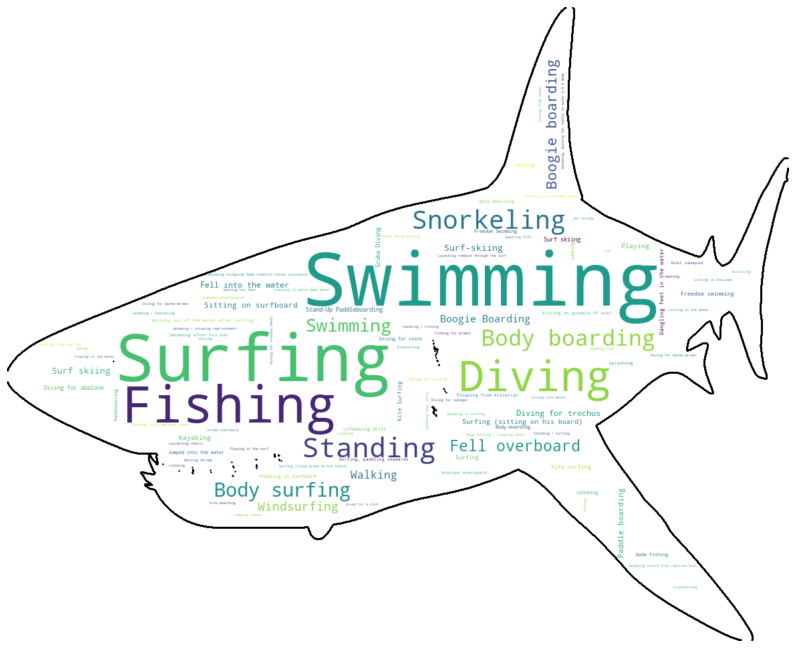

In [33]:
# Subset data and get value counts
sharksUnprovoked = sharks[sharks['Type'] == 'Unprovoked']
freqUnprovoked = dict(sharksUnprovoked['Activity'].value_counts())

# Create and generate a word cloud image:
wordcloudUnprovoked = WordCloud(contour_width=3, contour_color='black', prefer_horizontal=.9, min_font_size=5, max_words=1000, background_color="white", mask=mask).generate_from_frequencies(freqUnprovoked)
plt.figure(figsize = (14, 14), facecolor = None) 
plt.imshow(wordcloudUnprovoked) 
plt.imshow(wordcloudUnprovoked, interpolation='bilinear')
plt.axis("off")

# ¿Que hacía la gente cuando provocaban los ataques?

(-0.5, 1169.5, 948.5, -0.5)

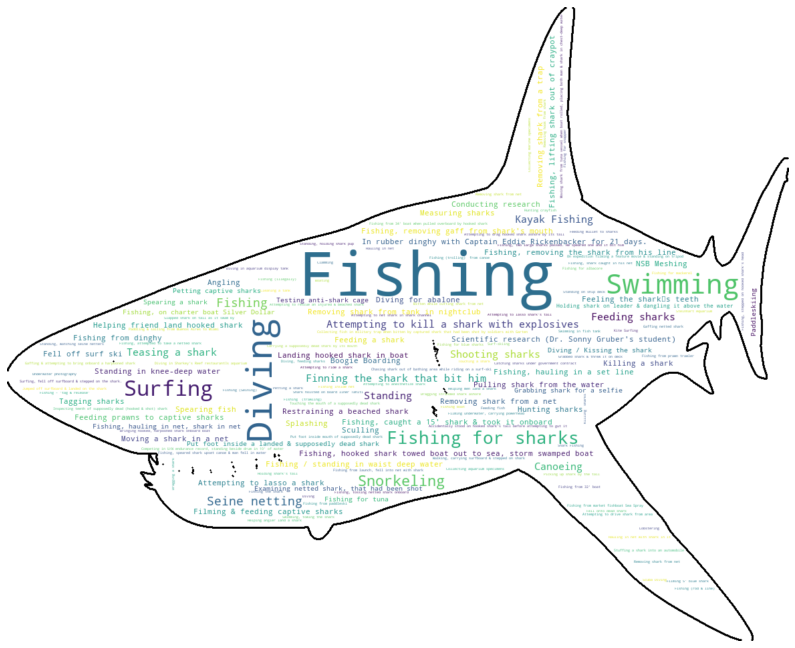

In [34]:
# Subset data frame 
sharksProvoked = sharks[sharks['Type'] == 'Provoked']

# Get the frequency counts
freqProvoked = dict(sharksProvoked['Activity'].value_counts())

# Create word cloud
wordcloudProvoked = WordCloud(contour_width=3, contour_color='black', prefer_horizontal=.9, min_font_size=5, max_words=1000, background_color="white", mask=mask).generate_from_frequencies(freqProvoked)

# Display the generated image:
plt.figure(figsize = (14, 14), facecolor = None) 
plt.imshow(wordcloudProvoked) 
plt.imshow(wordcloudProvoked, interpolation='bilinear')
plt.axis("off")

# Save final data frame

In [35]:
sharks.columns

Index(['Case Number', 'Date', 'Year', 'Type', 'Country', 'Area', 'Location',
       'Activity', 'Name', 'Sex ', 'Age', 'Injury', 'Fatal (Y/N)', 'Time',
       'Species ', 'Investigator or Source', 'pdf', 'href formula', 'href',
       'Case Number.1', 'Case Number.2', 'original order'],
      dtype='object')

In [36]:
sharks.to_csv("sharks_clean.csv", encoding='utf-8', index=False)